# Pytorch深度学习

### 基本配置

首先导入必须的包。对于一个PyTorch项目，我们需要导入一些Python常用的包来帮助我们快速实现功能。常见的包有os、numpy等，此外还需要调用PyTorch自身一些PyTorch的模块方便灵活使用，比如torch、torch.nn、torch.utils.data.Dataset、torch.utils.data.DataLoader、torch.optimizer等等。注意这里**只是建议导入的包导入的方式**，可以采用不同的方案，比如涉及到表格信息的读入很可能用到pandas，对于不同的项目可能还需要导入一些更上层的包如cv2等。如果涉及可视化还会用到matplotlib、seaborn等。涉及到下游分析和指标计算也常用到sklearn。

In [1]:
#引入包
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optimizer

In [2]:
'''
根据前面我们对深度学习任务的梳理，有如下几个超参数可以统一设置，方便后续调试时修改：
- batch size
- 初始学习率（初始）
- 训练次数（max_epochs）
- GPU配置
'''
batch_size = 16
lr = 1e-4
max_epochs = 100

In [3]:
#GPU的设置有两种常见的方式：
# 方案一：使用os.environ，这种情况如果使用GPU不需要设置
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'

# 方案二：使用“device”，后续对要使用GPU的变量用.to(device)即可
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

当然还会有一些其他模块或用户自定义模块会用到的参数，有需要也可以在一开始进行设置。

### 数据读入

PyTorch数据读入是通过Dataset+Dataloader的方式完成的，Dataset定义好数据的格式和数据变换形式，Dataloader用iterative的方式不断读入批次数据。

我们可以定义自己的Dataset类来实现灵活的数据读取，定义的类需要继承PyTorch自身的Dataset类。主要包含三个函数：

- `__init__`: 用于向类中传入外部参数，同时定义样本集
- `__getitem__`: 用于逐个读取样本集合中的元素，可以进行一定的变换，并将返回训练/验证所需的数据
- `__len__`: 用于返回数据集的样本数

下面以cifar10数据集为例给出构建Dataset类的方式：


```python
train_data = datasets.ImageFolder(train_path, transform=data_transform)
val_data = datasets.ImageFolder(val_path, transform=data_transform)
```

这里使用了PyTorch自带的ImageFolder类的用于读取按一定结构存储的图片数据（path对应图片存放的目录，目录下包含若干子目录，每个子目录对应一个类的图片）。

其中“data_transform”可以对图像进行一定的变换，如翻转、裁剪等操作，可自己定义。这里我们会在下一章通过实战加以介绍。

这里另外给出一个例子，其中图片存放在一个文件夹，另外有一个csv文件给出了图片名称对应的标签。这种情况下需要自己来定义Dataset类：

In [4]:
class MyDataset(Dataset):
    def __init__(self, data_dir, info_csv, image_list, transform=None):
        """
        Args:
            data_dir: path to image directory.
            info_csv: path to the csv file containing image indexes
                with corresponding labels.
            image_list: path to the txt file contains image names to training/validation set
            transform: optional transform to be applied on a sample.
        """
        label_info = pd.read_csv(info_csv)
        image_file = open(image_list).readlines()
        self.data_dir = data_dir
        self.image_file = image_file
        self.label_info = label_info
        self.transform = transform

    def __getitem__(self, index):
        """
        Args:
            index: the index of item
        Returns:
            image and its labels
        """
        image_name = self.image_file[index].strip('\n')
        raw_label = self.label_info.loc[self.label_info['Image_index'] == image_name]
        label = raw_label.iloc[:,0]
        image_name = os.path.join(self.data_dir, image_name)
        image = Image.open(image_name).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.image_file)

构建好Datadet后，就可以使用DataLoader来按批次读入数据了，实现代码如下：


```python
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=4, shuffle=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, num_workers=4, shuffle=False)
```

其中:

- batch_size：样本是按“批”读入的，batch_size就是每次读入的样本数
- num_workers：有多少个进程用于读取数据
- shuffle：是否将读入的数据打乱
- drop_last：对于样本最后一部分没有达到批次数的样本，不再参与训练

这里可以看一下我们的加载的数据。PyTorch中的DataLoader的读取可以使用next和iter来完成

```python
import matplotlib.pyplot as plt
images, labels = next(iter(val_loader))
print(images.shape)
plt.imshow(images[0].transpose(1,2,0))
plt.show()
```

## 模型构建

#### 3.4.1  神经网络的构造

PyTorch中神经网络构造一般是基于 Module 类的模型来完成的，它让模型构造更加灵活。

Module 类是 nn 模块里提供的一个模型构造类，是所有神经⽹网络模块的基类，我们可以继承它来定义我们想要的模型。下面继承 Module 类构造多层感知机。这里定义的 MLP 类重载了 Module 类的 init 函数和 forward 函数。它们分别用于创建模型参数和定义前向计算。前向计算也即正向传播。

In [5]:
import torch
from torch import nn

class MLP(nn.Module):
  # 声明带有模型参数的层，这里声明了两个全连接层
  def __init__(self, **kwargs):
    # 调用MLP父类Block的构造函数来进行必要的初始化。这样在构造实例例时还可以指定其他函数
    super(MLP, self).__init__(**kwargs)
    self.hidden = nn.Linear(784, 256)
    self.act = nn.ReLU()
    self.output = nn.Linear(256,10)
    
   # 定义模型的前向计算，即如何根据输入x计算返回所需要的模型输出
  def forward(self, x):
    o = self.act(self.hidden(x))
    return self.output(o)   

以上的 MLP 类中⽆无须定义反向传播函数。系统将通过⾃动求梯度⽽自动⽣成反向传播所需的 backward 函数。

我们可以实例化 MLP 类得到模型变量 net 。下⾯的代码初始化 net 并传入输⼊数据 X 做一次前向计算。其中， net(X) 会调用 MLP 继承⾃自 Module 类的 __call__ 函数，这个函数将调⽤用 MLP 类定义的forward 函数来完成前向计算。

In [6]:
X = torch.rand(2,784)
net = MLP()
print(net)
net(X)

MLP(
  (hidden): Linear(in_features=784, out_features=256, bias=True)
  (act): ReLU()
  (output): Linear(in_features=256, out_features=10, bias=True)
)


tensor([[-0.1626,  0.0354, -0.0072,  0.1289,  0.0699, -0.0441, -0.1062,  0.0483,
         -0.4259,  0.2505],
        [-0.1299, -0.1311, -0.0107,  0.2428,  0.1173, -0.0040, -0.0029, -0.0319,
         -0.4464,  0.2602]], grad_fn=<AddmmBackward>)

注意，这里并没有将 Module 类命名为 Layer (层)或者 Model (模型)之类的名字，这是因为该类是一个可供⾃由组建的部件。它的子类既可以是⼀个层(如PyTorch提供的 Linear 类)，⼜可以是一个模型(如这里定义的 MLP 类)，或者是模型的⼀个部分。

#### 3.4.2  神经网络中常见的层

深度学习的一个魅力在于神经网络中各式各样的层，例如全连接层、卷积层、池化层与循环层等等。虽然PyTorch提供了⼤量常用的层，但有时候我们依然希望⾃定义层。这里我们会介绍如何使用 Module 来自定义层，从而可以被反复调用。

- **不含模型参数的层**

我们先介绍如何定义一个不含模型参数的自定义层。下⾯构造的 MyLayer 类通过继承 Module 类自定义了一个**将输入减掉均值后输出**的层，并将层的计算定义在了 forward 函数里。这个层里不含模型参数。

In [7]:
import torch
from torch import nn

class MyLayer(nn.Module):
    def __init__(self, **kwargs):
        super(MyLayer, self).__init__(**kwargs)
    def forward(self, x):
        return x - x.mean()  

测试，实例化该层，然后做前向计算


In [8]:
layer = MyLayer()
layer(torch.tensor([1, 2, 3, 4, 5], dtype=torch.float))

tensor([-2., -1.,  0.,  1.,  2.])

- **含模型参数的层**

我们还可以自定义含模型参数的自定义层。其中的模型参数可以通过训练学出。

Parameter 类其实是 Tensor 的子类，如果一 个 Tensor 是 Parameter ，那么它会⾃动被添加到模型的参数列表里。所以在⾃定义含模型参数的层时，我们应该将参数定义成 Parameter ，除了直接定义成 Parameter 类外，还可以使⽤ ParameterList 和 ParameterDict 分别定义参数的列表和字典。

In [9]:
class MyListDense(nn.Module):
    def __init__(self):
        super(MyListDense, self).__init__()
        self.params = nn.ParameterList([nn.Parameter(torch.randn(4, 4)) for i in range(3)])
        self.params.append(nn.Parameter(torch.randn(4, 1)))

    def forward(self, x):
        for i in range(len(self.params)):
            x = torch.mm(x, self.params[i])
        return x
net = MyListDense()
print(net)

class MyDictDense(nn.Module):
    def __init__(self):
        super(MyDictDense, self).__init__()
        self.params = nn.ParameterDict({
                'linear1': nn.Parameter(torch.randn(4, 4)),
                'linear2': nn.Parameter(torch.randn(4, 1))
        })
        self.params.update({'linear3': nn.Parameter(torch.randn(4, 2))}) # 新增

    def forward(self, x, choice='linear1'):
        return torch.mm(x, self.params[choice])

net = MyDictDense()
print(net)

MyListDense(
  (params): ParameterList(
      (0): Parameter containing: [torch.FloatTensor of size 4x4]
      (1): Parameter containing: [torch.FloatTensor of size 4x4]
      (2): Parameter containing: [torch.FloatTensor of size 4x4]
      (3): Parameter containing: [torch.FloatTensor of size 4x1]
  )
)
MyDictDense(
  (params): ParameterDict(
      (linear1): Parameter containing: [torch.FloatTensor of size 4x4]
      (linear2): Parameter containing: [torch.FloatTensor of size 4x1]
      (linear3): Parameter containing: [torch.FloatTensor of size 4x2]
  )
)


下面给出常见的神经网络的一些层，比如卷积层、池化层，以及较为基础的AlexNet，LeNet等。

- **二维卷积层**

二维卷积层将输入和卷积核做互相关运算，并加上一个标量偏差来得到输出。卷积层的模型参数包括了卷积核和标量偏差。在训练模型的时候，通常我们先对卷积核随机初始化，然后不不断迭代卷积核和偏差。

In [10]:
import torch
from torch import nn

# 卷积运算（二维互相关）
def corr2d(X, K): 
    h, w = K.shape
    X, K = X.float(), K.float()
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i: i + h, j: j + w] * K).sum()
    return Y

# 二维卷积层
class Conv2D(nn.Module):
    def __init__(self, kernel_size):
        super(Conv2D, self).__init__()
        self.weight = nn.Parameter(torch.randn(kernel_size))
        self.bias = nn.Parameter(torch.randn(1))

    def forward(self, x):
        return corr2d(x, self.weight) + self.bias

卷积窗口形状为 $p \times q$ 的卷积层称为 $p \times q$  卷积层。同样，  $p \times q$ 卷积或 $p \times q$ 卷积核说明卷积核的高和宽分别为 $p$ 和 $q$。

填充(padding)是指在输⼊入⾼高和宽的两侧填充元素(通常是0元素)。

下面的例子里我们创建一个⾼和宽为3的二维卷积层，然后设输⼊高和宽两侧的填充数分别为1。给定一 个高和宽为8的输入，我们发现输出的高和宽也是8。

In [11]:
import torch
from torch import nn

# 定义一个函数来计算卷积层。它对输入和输出做相应的升维和降维
def comp_conv2d(conv2d, X):
    # (1, 1)代表批量量⼤大⼩小和通道数
    X = X.view((1, 1) + X.shape)
    Y = conv2d(X)
    return Y.view(Y.shape[2:]) # 排除不关心的前两维:批量和通道


# 注意这里是两侧分别填充1⾏或列，所以在两侧一共填充2⾏或列
conv2d = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3,padding=1)

X = torch.rand(8, 8)
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

当卷积核的高和宽不同时，我们也可以通过设置高和宽上不同的填充数使输出和输入具有相同的高和宽。

In [12]:
# 使⽤用高为5、宽为3的卷积核。在⾼和宽两侧的填充数分别为2和1
conv2d = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(5, 3), padding=(2, 1))
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

在二维互相关运算中，卷积窗口从输入数组的最左上方开始，按从左往右、从上往下 的顺序，依次在输⼊数组上滑动。我们将每次滑动的行数和列数称为步幅(stride)。

In [13]:
conv2d = nn.Conv2d(1, 1, kernel_size=(3, 5), padding=(0, 1), stride=(3, 4))
comp_conv2d(conv2d, X).shape

torch.Size([2, 2])

填充可以增加输出的高和宽。这常用来使输出与输入具有相同的高和宽。

步幅可以减小输出的高和宽，例如输出的高和宽仅为输⼊入的高和宽的 ( 为大于1的整数)。

- **池化层**

池化层每次对输入数据的一个固定形状窗口(⼜称池化窗口)中的元素计算输出。不同于卷积层里计算输⼊和核的互相关性，池化层直接计算池化窗口内元素的最大值或者平均值。该运算也 分别叫做最大池化或平均池化。在二维最⼤池化中，池化窗⼝口从输⼊入数组的最左上⽅方开始，按从左往右、从上往下的顺序，依次在输⼊数组上滑动。当池化窗口滑动到某⼀位置时，窗口中的输入子数组的最大值即输出数组中相应位置的元素。

下面把池化层的前向计算实现在`pool2d`函数里。

In [14]:
import torch
from torch import nn

import numpy as np

def pool2d(X, pool_size, mode='max'):
    p_h, p_w = pool_size
    Y = np.zeros((X.shape[0] - p_h + 1, X.shape[1] - p_w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if mode == 'max':
                Y[i, j] = X[i: i + p_h, j: j + p_w].max()
            elif mode == 'avg':
                Y[i, j] = X[i: i + p_h, j: j + p_w].float().mean()
    return Y

X = torch.tensor([[0, 1, 2], [3, 4, 5], [6, 7, 8]])
pool2d(X, (2, 2))

array([[4., 5.],
       [7., 8.]])

In [15]:
pool2d(X, (2, 2), 'avg')

array([[2., 3.],
       [5., 6.]])

我们可以使用`torch.nn`包来构建神经网络。我们已经介绍了`autograd`包，`nn`包则依赖于`autograd`包来定义模型并对它们求导。一个`nn.Module`包含各个层和一个`forward(input)`方法，该方法返回`output`。

#### 3.4.3  模型示例

- **LeNet**
![3.4.1](./figures/3.4.1.png)

这是一个简单的前馈神经网络 (feed-forward network）（LeNet）。它接受一个输入，然后将它送入下一层，一层接一层的传递，最后给出输出。

一个神经网络的典型训练过程如下：

1. 定义包含一些可学习参数(或者叫权重）的神经网络
2. 在输入数据集上迭代
3. 通过网络处理输入
4. 计算 loss (输出和正确答案的距离）
5. 将梯度反向传播给网络的参数
6. 更新网络的权重，一般使用一个简单的规则：`weight = weight - learning_rate * gradient`

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 输入图像channel：1；输出channel：6；5x5卷积核
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # 2x2 Max pooling
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # 如果是方阵,则可以只使用一个数字进行定义
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # 除去批处理维度的其他所有维度
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


我们只需要定义 `forward` 函数，`backward`函数会在使用`autograd`时自动定义，`backward`函数用来计算导数。我们可以在 `forward` 函数中使用任何针对张量的操作和计算。

一个模型的可学习参数可以通过`net.parameters()`返回

In [17]:
params = list(net.parameters())
print(len(params))
print(params[0].size())  # conv1的权重

10
torch.Size([6, 1, 5, 5])


让我们尝试一个随机的 32x32 的输入。注意:这个网络 (LeNet）的期待输入是 32x32 的张量。如果使用 MNIST 数据集来训练这个网络，要把图片大小重新调整到 32x32。

In [18]:
input = torch.randn(1, 1, 32, 32)
out = net(input)
print(out)

tensor([[-0.0682,  0.0772, -0.0188, -0.0306,  0.1010, -0.0488, -0.0829, -0.1138,
          0.0266, -0.0160]], grad_fn=<AddmmBackward>)


清零所有参数的梯度缓存，然后进行随机梯度的反向传播：

In [19]:
net.zero_grad()
out.backward(torch.randn(1, 10))

注意：`torch.nn`只支持小批量处理 (mini-batches）。整个 `torch.nn` 包只支持小批量样本的输入，不支持单个样本的输入。比如，`nn.Conv2d` 接受一个4维的张量，即`nSamples x nChannels x Height x Width `如果是一个单独的样本，只需要使用`input.unsqueeze(0)` 来添加一个“假的”批大小维度。

- `torch.Tensor` - 一个多维数组，支持诸如`backward()`等的自动求导操作，同时也保存了张量的梯度。

- `nn.Module `- 神经网络模块。是一种方便封装参数的方式，具有将参数移动到GPU、导出、加载等功能。

- `nn.Parameter `- 张量的一种，当它作为一个属性分配给一个`Module`时，它会被自动注册为一个参数。

- `autograd.Function` - 实现了自动求导前向和反向传播的定义，每个`Tensor`至少创建一个`Function`节点，该节点连接到创建`Tensor`的函数并对其历史进行编码。

下面再介绍一个比较基础的案例AlexNet


- **AlexNet**

![3.4.2](./figures/3.4.2.png)

In [20]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 96, 11, 4), # in_channels, out_channels, kernel_size, stride, padding
            nn.ReLU(),
            nn.MaxPool2d(3, 2), # kernel_size, stride
            # 减小卷积窗口，使用填充为2来使得输入与输出的高和宽一致，且增大输出通道数
            nn.Conv2d(96, 256, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(3, 2),
            # 连续3个卷积层，且使用更小的卷积窗口。除了最后的卷积层外，进一步增大了输出通道数。
            # 前两个卷积层后不使用池化层来减小输入的高和宽
            nn.Conv2d(256, 384, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(384, 384, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(384, 256, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(3, 2)
        )
         # 这里全连接层的输出个数比LeNet中的大数倍。使用丢弃层来缓解过拟合
        self.fc = nn.Sequential(
            nn.Linear(256*5*5, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            # 输出层。由于这里使用Fashion-MNIST，所以用类别数为10，而非论文中的1000
            nn.Linear(4096, 10),
        )

    def forward(self, img):
        feature = self.conv(img)
        output = self.fc(feature.view(img.shape[0], -1))
        return output

In [21]:
net = AlexNet()
print(net)

AlexNet(
  (conv): Sequential(
    (0): Conv2d(1, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=6400, out_features=4096, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5)
    (3): Linear(in_features=4096, out_features=4096, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5)
    (6): Linear(in_features=4096, o

## 损失函数

在深度学习广为盛行的今天，我们可以在脑海里清晰的知道，一个模型要可以达到很好的效果需要学习，也就是我们常说的训练。一个好的训练离不开优质的负反馈，这里的损失函数就是模型的负反馈。

![](./figures/3.5.1lossfunciton.png)

所以在PyTorch中，损失函数是必不可少的。它是数据输入到模型当中，产生的结果与真实标签的评价指标，我们的模型可以按照损失函数的目标来做出改进。

下面我们将开始探索pytorch的所拥有的损失函数。这里将列出PyTorch中常用的损失函数（一般通过torch.nn调用），并详细介绍每个损失函数的功能介绍、数学公式和调用代码。当然，PyTorch的损失函数还远不止这些，在解决实际问题的过程中需要进一步探索、借鉴现有工作，或者设计自己的损失函数。

#### 3.5.1  二分类交叉熵损失函数

In [22]:
torch.nn.BCELoss(weight=None, size_average=None, reduce=None, reduction='mean')

BCELoss()

**功能**：计算二分类任务时的交叉熵（Cross Entropy）函数。在二分类中，label是{0,1}。对于进入交叉熵函数的input为概率分布的形式。一般来说，input为sigmoid激活层的输出，或者softmax的输出。

**主要参数**：
`weight`:每个类别的loss设置权值

`size_average`:数据为bool，为True时，返回的loss为平均值；为False时，返回的各样本的loss之和。

`reduce`:数据类型为bool，为True时，loss的返回是标量。

计算公式如下：
$$
\ell(x, y)=\left\{\begin{array}{ll}
\operatorname{mean}(L), & \text { if reduction }=\text { 'mean' } \\
\operatorname{sum}(L), & \text { if reduction }=\text { 'sum' }
\end{array}\right.
$$

In [23]:
m = nn.Sigmoid()
loss = nn.BCELoss()
input = torch.randn(3, requires_grad=True)
target = torch.empty(3).random_(2)
output = loss(m(input), target)
output.backward()

In [24]:
print('BCELoss损失函数的计算结果为',output)

BCELoss损失函数的计算结果为 tensor(0.8558, grad_fn=<BinaryCrossEntropyBackward>)


#### 3.5.2  交叉熵损失函数

In [25]:
torch.nn.CrossEntropyLoss(weight=None, size_average=None, ignore_index=-100, reduce=None, reduction='mean')

CrossEntropyLoss()

**功能**：计算交叉熵函数

**主要参数**：
`weight`:每个类别的loss设置权值。

`size_average`:数据为bool，为True时，返回的loss为平均值；为False时，返回的各样本的loss之和。

`ignore_index`:忽略某个类的损失函数。

`reduce`:数据类型为bool，为True时，loss的返回是标量。

计算公式如下：
$$
\operatorname{loss}(x, \text { class })=-\log \left(\frac{\exp (x[\text { class }])}{\sum_{j} \exp (x[j])}\right)=-x[\text { class }]+\log \left(\sum_{j} \exp (x[j])\right)
$$

In [26]:
loss = nn.CrossEntropyLoss()
input = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)
output = loss(input, target)
output.backward()

In [27]:
print(output)

tensor(2.4255, grad_fn=<NllLossBackward>)


#### 3.5.3  L1损失函数


In [28]:
torch.nn.L1Loss(size_average=None, reduce=None, reduction='mean')

L1Loss()

**功能：** 计算输出`y`和真实标签`target`之间的差值的绝对值。

我们需要知道的是，`reduction`参数决定了计算模式。有三种计算模式可选：none：逐个元素计算。
sum：所有元素求和，返回标量。
mean：加权平均，返回标量。 
如果选择`none`，那么返回的结果是和输入元素相同尺寸的。默认计算方式是求平均。

**计算公式如下：**
$$
L_{n} = | x_{n}-y_{n}|g)
$$


In [29]:
loss = nn.L1Loss()
input = torch.randn(3, 5, requires_grad=True)
target = torch.randn(3, 5)
output = loss(input, target)
output.backward()

In [30]:
print('L1损失函数的计算结果为',output)

L1损失函数的计算结果为 tensor(0.7951, grad_fn=<L1LossBackward>)


#### 3.5.4  MSE损失函数

In [31]:
torch.nn.MSELoss(size_average=None, reduce=None, reduction='mean')

MSELoss()

*功能：**计算输出`y`和真实标签`target`之差的平方。

和`L1Loss`一样，`MSELoss`损失函数中，`reduction`参数决定了计算模式。有三种计算模式可选：none：逐个元素计算。
sum：所有元素求和，返回标量。默认计算方式是求平均。

**计算公式如下：**

$$
l_{n}=\left(x_{n}-y_{n}\right)^{2}
$$


In [32]:
loss = nn.MSELoss()
input = torch.randn(3, 5, requires_grad=True)
target = torch.randn(3, 5)
output = loss(input, target)
output.backward()

In [33]:
print('MSE损失函数的计算结果为',output)

MSE损失函数的计算结果为 tensor(2.0590, grad_fn=<MseLossBackward>)


#### 3.5.5  平滑L1 (Smooth L1)损失函数

In [34]:
torch.nn.SmoothL1Loss(size_average=None, reduce=None, reduction='mean')

SmoothL1Loss()

**功能：** L1的平滑输出，其功能是减轻离群点带来的影响

`reduction`参数决定了计算模式。有三种计算模式可选：none：逐个元素计算。
sum：所有元素求和，返回标量。默认计算方式是求平均。

**提醒：** 之后的损失函数中，关于`reduction` 这个参数依旧会存在。所以，之后就不再单独说明。

**计算公式如下：**
$$
\operatorname{loss}(x, y)=\frac{1}{n} \sum_{i=1}^{n} z_{i}
$$
其中，
$$
z_{i}=\left\{\begin{array}{ll}
0.5\left(x_{i}-y_{i}\right)^{2}, & \text { if }\left|x_{i}-y_{i}\right|<1 \\
\left|x_{i}-y_{i}\right|-0.5, & \text { otherwise }
\end{array}\right.
$$


In [35]:
loss = nn.SmoothL1Loss()
input = torch.randn(3, 5, requires_grad=True)
target = torch.randn(3, 5)
output = loss(input, target)
output.backward()

In [36]:
print('SmoothL1Loss损失函数的计算结果为',output)

SmoothL1Loss损失函数的计算结果为 tensor(0.8822, grad_fn=<SmoothL1LossBackward>)


**平滑L1与L1的对比**

这里我们通过可视化两种损失函数曲线来对比平滑L1和L1两种损失函数的区别。

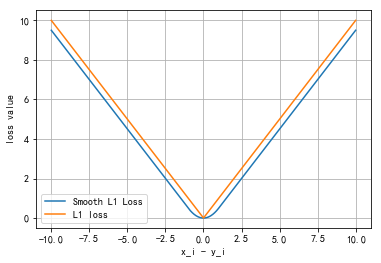

In [37]:
torch.Tensor.ndim = property(lambda self: len(self.shape))
inputs = torch.linspace(-10, 10, steps=5000)
target = torch.zeros_like(inputs)

loss_f_smooth = nn.SmoothL1Loss(reduction='none')
loss_smooth = loss_f_smooth(inputs, target)
loss_f_l1 = nn.L1Loss(reduction='none')
loss_l1 = loss_f_l1(inputs,target)

plt.plot(inputs.numpy(), loss_smooth.numpy(), label='Smooth L1 Loss')
plt.plot(inputs.numpy(), loss_l1, label='L1 loss')
plt.xlabel('x_i - y_i')
plt.ylabel('loss value')
plt.legend()
plt.grid()
plt.show()

可以看得出来，对于`smoothL1`来说，在0这个尖端处，过度更为平滑。


#### 3.5.6  目标泊松分布的负对数似然损失

In [38]:
torch.nn.PoissonNLLLoss(log_input=True, full=False, size_average=None, eps=1e-08, reduce=None, reduction='mean')


PoissonNLLLoss()

**功能：** 泊松分布的负对数似然损失函数

**主要参数：**

`log_input`：输入是否为对数形式，决定计算公式。

`full`：计算所有 loss，默认为 False。

`eps`：修正项，避免 input 0 为  时，log(input) 为 nan 的情况。

**数学公式：**

- 当参数`log_input=True`：
$$
    \operatorname{loss}\left(x_{n}, y_{n}\right)=e^{x_{n}}-x_{n} \cdot y_{n}
$$


- 当参数`log_input=False`：

    $$
    \operatorname{loss}\left(x_{n}, y_{n}\right)=x_{n}-y_{n} \cdot \log \left(x_{n}+\text { eps }\right)
    $$

In [39]:
loss = nn.PoissonNLLLoss()
log_input = torch.randn(5, 2, requires_grad=True)
target = torch.randn(5, 2)
output = loss(log_input, target)
output.backward()

print('PoissonNLLLoss损失函数的计算结果为',output)

PoissonNLLLoss损失函数的计算结果为 tensor(1.2638, grad_fn=<MeanBackward1>)


#### 3.5.7  KL散度

In [40]:
torch.nn.KLDivLoss(size_average=None, reduce=None, reduction='mean')

KLDivLoss()

**功能：** 计算KL散度，也就是计算相对熵。用于连续分布的距离度量，并且对离散采用的连续输出空间分布进行回归通常很有用。

**主要参数:** 

`reduction`：计算模式，可为 `none`/`sum`/`mean`/`batchmean`。

    none：逐个元素计算。
    
    sum：所有元素求和，返回标量。
    
    mean：加权平均，返回标量。
    
    batchmean：batchsize 维度求平均值。

**计算公式：**

$$
\begin{aligned}
D_{\mathrm{KL}}(P, Q)=\mathrm{E}_{X \sim P}\left[\log \frac{P(X)}{Q(X)}\right] &=\mathrm{E}_{X \sim P}[\log P(X)-\log Q(X)] \\
&=\sum_{i=1}^{n} P\left(x_{i}\right)\left(\log P\left(x_{i}\right)-\log Q\left(x_{i}\right)\right)
\end{aligned}
$$


In [41]:
inputs = torch.tensor([[0.5, 0.3, 0.2], [0.2, 0.3, 0.5]])
target = torch.tensor([[0.9, 0.05, 0.05], [0.1, 0.7, 0.2]], dtype=torch.float)
loss = nn.KLDivLoss()
output = loss(inputs,target)

print('PoissonNLLLoss损失函数的计算结果为',output)

PoissonNLLLoss损失函数的计算结果为 tensor(-0.3335)


/home/ma-user/anaconda3/envs/Pytorch-1.0.0/lib/python3.6/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


#### 3.5.8  MarginRankingLoss

In [42]:
torch.nn.MarginRankingLoss(margin=0.0, size_average=None, reduce=None, reduction='mean')

MarginRankingLoss()

**功能：** 计算两个向量之间的相似度，用于排序任务。该方法计算两组数据之间的差异。

**主要参数:** 

`margin`：边界值，$$x_{1}$$ 与$$x_{2}$$ 之间的差异值。

`reduction`：计算模式，可为 none/sum/mean。

**计算公式：**

$$
\operatorname{loss}(x 1, x 2, y)=\max (0,-y *(x 1-x 2)+\operatorname{margin})
$$


In [43]:
loss = nn.MarginRankingLoss()
input1 = torch.randn(3, requires_grad=True)
input2 = torch.randn(3, requires_grad=True)
target = torch.randn(3).sign()
output = loss(input1, input2, target)
output.backward()

print('MarginRankingLoss损失函数的计算结果为',output)

MarginRankingLoss损失函数的计算结果为 tensor(0., grad_fn=<MeanBackward1>)


#### 3.5.9  多标签边界损失函数

In [44]:
torch.nn.MultiLabelMarginLoss(size_average=None, reduce=None, reduction='mean')

MultiLabelMarginLoss()

**功能：** 对于多标签分类问题计算损失函数。

**主要参数:** 


`reduction`：计算模式，可为 none/sum/mean。

**计算公式：**
$$
\operatorname{loss}(x, y)=\sum_{i j} \frac{\max (0,1-x[y[j]]-x[i])}{x \cdot \operatorname{size}(0)}
$$

$$
\begin{array}{l}
\text { 其中, } i=0, \ldots, x \cdot \operatorname{size}(0), j=0, \ldots, y \cdot \operatorname{size}(0), \text { 对于所有的 } i \text { 和 } j \text {, 都有 } y[j] \geq 0 \text { 并且 }\\
i \neq y[j]
\end{array}
$$


In [45]:
loss = nn.MultiLabelMarginLoss()
x = torch.FloatTensor([[0.9, 0.2, 0.4, 0.8]])
# for target y, only consider labels 3 and 0, not after label -1
y = torch.LongTensor([[3, 0, -1, 1]])# 真实的分类是，第3类和第0类
output = loss(x, y)

print('MarginRankingLoss损失函数的计算结果为',output)

MarginRankingLoss损失函数的计算结果为 tensor(0.4500)


#### 3.5.10  二分类损失函数

In [46]:
torch.nn.SoftMarginLoss(size_average=None, reduce=None, reduction='mean')

SoftMarginLoss()

**功能：** 二分类的 logistic 损失。

**主要参数:** 


`reduction`：计算模式，可为 none/sum/mean。

**计算公式：**

$$
\operatorname{loss}(x, y)=\sum_{i} \frac{\log (1+\exp (-y[i] \cdot x[i]))}{x \cdot \operatorname{nelement}()}
$$

$$
\
\text { 其中, } x . \text { nelement() 为输入 } x \text { 中的样本个数。注意这里 } y \text { 也有 } 1 \text { 和 }-1 \text { 两种模式。 }
\
$$

In [47]:
inputs = torch.tensor([[0.3, 0.7], [0.5, 0.5]])  # 两个样本，两个神经元
target = torch.tensor([[-1, 1], [1, -1]], dtype=torch.float)  # 该 loss 为逐个神经元计算，需要为每个神经元单独设置标签

loss_f = nn.SoftMarginLoss()
output = loss_f(inputs, target)

print('SoftMarginLoss损失函数的计算结果为',output)

SoftMarginLoss损失函数的计算结果为 tensor(0.6764)


#### 3.5.11  多分类的折页损失

In [48]:
torch.nn.MultiMarginLoss(p=1, margin=1.0, weight=None, size_average=None, reduce=None, reduction='mean')

MultiMarginLoss()

**功能：** 计算多分类的折页损失

**主要参数:** 


`reduction`：计算模式，可为 none/sum/mean。

`p：`可选 1 或 2。

`weight`：各类别的 loss 设置权值。

`margin`：边界值


**计算公式：**

$$
\operatorname{loss}(x, y)=\frac{\sum_{i} \max (0, \operatorname{margin}-x[y]+x[i])^{p}}{x \cdot \operatorname{size}(0)}
$$

$$
\begin{array}{l}
\text { 其中, } x \in\{0, \ldots, x \cdot \operatorname{size}(0)-1\}, y \in\{0, \ldots, y \cdot \operatorname{size}(0)-1\} \text {, 并且对于所有的 } i \text { 和 } j \text {, }\\
\text { 都有 } 0 \leq y[j] \leq x \cdot \operatorname{size}(0)-1, \text { 以及 } i \neq y[j] \text { 。 }
\end{array}
$$


In [49]:
inputs = torch.tensor([[0.3, 0.7], [0.5, 0.5]]) 
target = torch.tensor([0, 1], dtype=torch.long) 

loss_f = nn.MultiMarginLoss()
output = loss_f(inputs, target)

print('MultiMarginLoss损失函数的计算结果为',output)

MultiMarginLoss损失函数的计算结果为 tensor(0.6000)


#### 3.5.12  三元组损失

In [50]:
torch.nn.TripletMarginLoss(margin=1.0, p=2.0, eps=1e-06, swap=False, size_average=None, reduce=None, reduction='mean')

TripletMarginLoss()

**功能：** 计算三元组损失。

**三元组:** 这是一种数据的存储或者使用格式。<实体1，关系，实体2>。在项目中，也可以表示为< `anchor`, `positive examples` , `negative examples`>

在这个损失函数中，我们希望去`anchor`的距离更接近`positive examples`，而远离`negative examples `

**主要参数:** 


`reduction`：计算模式，可为 none/sum/mean。

`p：`可选 1 或 2。


`margin`：边界值


**计算公式：**

$$
L(a, p, n)=\max \left\{d\left(a_{i}, p_{i}\right)-d\left(a_{i}, n_{i}\right)+\operatorname{margin}, 0\right\}
$$

$$
\text { 其中, } d\left(x_{i}, y_{i}\right)=\left\|\mathbf{x}_{i}-\mathbf{y}_{i}\right\|_{\text {・ }}
$$

In [51]:
triplet_loss = nn.TripletMarginLoss(margin=1.0, p=2)
anchor = torch.randn(100, 128, requires_grad=True)
positive = torch.randn(100, 128, requires_grad=True)
negative = torch.randn(100, 128, requires_grad=True)
output = triplet_loss(anchor, positive, negative)
output.backward()
print('TripletMarginLoss损失函数的计算结果为',output)

TripletMarginLoss损失函数的计算结果为 tensor(1.0442, grad_fn=<MeanBackward1>)


#### 3.5.13  HingEmbeddingLoss

In [52]:
torch.nn.HingeEmbeddingLoss(margin=1.0, size_average=None, reduce=None, reduction='mean')

HingeEmbeddingLoss()

**功能：** 对输出的embedding结果做Hing损失计算

**主要参数:** 


`reduction`：计算模式，可为 none/sum/mean。



`margin`：边界值


**计算公式：**

$$
l_{n}=\left\{\begin{array}{ll}
x_{n}, & \text { if } y_{n}=1 \\
\max \left\{0, \Delta-x_{n}\right\}, & \text { if } y_{n}=-1
\end{array}\right.
$$
**注意事项：** 输入x应为两个输入之差的绝对值。

可以这样理解，让个输出的是正例yn=1,那么loss就是x，如果输出的是负例y=-1，那么输出的loss就是要做一个比较。

In [53]:
loss_f = nn.HingeEmbeddingLoss()
inputs = torch.tensor([[1., 0.8, 0.5]])
target = torch.tensor([[1, 1, -1]])
output = loss_f(inputs,target)

print('HingEmbeddingLoss损失函数的计算结果为',output)

HingEmbeddingLoss损失函数的计算结果为 tensor(0.7667)


#### 3.5.14  余弦相似度

In [54]:
torch.nn.CosineEmbeddingLoss(margin=0.0, size_average=None, reduce=None, reduction='mean')

CosineEmbeddingLoss()

**功能：** 对与两个向量做余弦相似度

**主要参数:** 


`reduction`：计算模式，可为 none/sum/mean。



`margin`：可取值[-1,1] ，推荐为[0,0.5] 。


**计算公式：**

$$
\operatorname{loss}(x, y)=\left\{\begin{array}{ll}
1-\cos \left(x_{1}, x_{2}\right), & \text { if } y=1 \\
\max \left\{0, \cos \left(x_{1}, x_{2}\right)-\text { margin }\right\}, & \text { if } y=-1
\end{array}\right.
$$
其中,
$$
\cos (\theta)=\frac{A \cdot B}{\|A\|\|B\|}=\frac{\sum_{i=1}^{n} A_{i} \times B_{i}}{\sqrt{\sum_{i=1}^{n}\left(A_{i}\right)^{2}} \times \sqrt{\sum_{i=1}^{n}\left(B_{i}\right)^{2}}}
$$


这个损失函数应该是最广为人知道的。对于两个向量，做余弦相似度。将余弦相似度作为一个距离的计算方式，如果两个向量的距离近，则损失函数值小，反之亦然。

In [55]:
loss_f = nn.CosineEmbeddingLoss()
inputs_1 = torch.tensor([[0.3, 0.5, 0.7], [0.3, 0.5, 0.7]])
inputs_2 = torch.tensor([[0.1, 0.3, 0.5], [0.1, 0.3, 0.5]])
target = torch.tensor([[1, -1]], dtype=torch.float)
output = loss_f(inputs_1,inputs_2,target)

print('CosineEmbeddingLoss损失函数的计算结果为',output)

CosineEmbeddingLoss损失函数的计算结果为 tensor(0.5000)


#### 3.5.15  CTC损失函数

In [56]:
torch.nn.CTCLoss(blank=0, reduction='mean')

CTCLoss()

**功能：** 用于解决时序类数据的分类

计算连续时间序列和目标序列之间的损失。CTCLoss对输入和目标的可能排列的概率进行求和，产生一个损失值，这个损失值对每个输入节点来说是可分的。输入与目标的对齐方式被假定为 "多对一"，这就限制了目标序列的长度，使其必须是≤输入长度。

**主要参数:** 


`reduction`：计算模式，可为 none/sum/mean。


`blank`：blank label。


`zero_infinity`：无穷大的值或梯度值为 

In [57]:
# Target are to be padded
T = 50      # Input sequence length
C = 20      # Number of classes (including blank)
N = 16      # Batch size
S = 30      # Target sequence length of longest target in batch (padding length)
S_min = 10  # Minimum target length, for demonstration purposes

# Initialize random batch of input vectors, for *size = (T,N,C)
input = torch.randn(T, N, C).log_softmax(2).detach().requires_grad_()

# Initialize random batch of targets (0 = blank, 1:C = classes)
target = torch.randint(low=1, high=C, size=(N, S), dtype=torch.long)

input_lengths = torch.full(size=(N,), fill_value=T, dtype=torch.long)
target_lengths = torch.randint(low=S_min, high=S, size=(N,), dtype=torch.long)
ctc_loss = nn.CTCLoss()
loss = ctc_loss(input, target, input_lengths, target_lengths)
loss.backward()


# Target are to be un-padded
T = 50      # Input sequence length
C = 20      # Number of classes (including blank)
N = 16      # Batch size

# Initialize random batch of input vectors, for *size = (T,N,C)
input = torch.randn(T, N, C).log_softmax(2).detach().requires_grad_()
input_lengths = torch.full(size=(N,), fill_value=T, dtype=torch.long)

# Initialize random batch of targets (0 = blank, 1:C = classes)
target_lengths = torch.randint(low=1, high=T, size=(N,), dtype=torch.long)
target = torch.randint(low=1, high=C, size=(sum(target_lengths),), dtype=torch.long)
ctc_loss = nn.CTCLoss()
loss = ctc_loss(input, target, input_lengths, target_lengths)
loss.backward()

print('CTCLoss损失函数的计算结果为',loss)

CTCLoss损失函数的计算结果为 tensor(5.5996, grad_fn=<MeanBackward1>)


## Pytorch优化器

#### 3.6.1  什么是优化器

深度学习的目标是通过不断改变网络参数，使得参数能够对输入做各种非线性变换拟合输出，本质上就是一个函数去寻找最优解，只不过这个最优解使一个矩阵，而如何快速求得这个最优解是深度学习研究的一个重点，以经典的resnet-50为例，它大约有2000万个系数需要进行计算，那么我们如何计算出来这么多的系数，有以下两种方法：

1. 第一种是最直接的暴力穷举一遍参数，这种方法的实施可能性基本为0，堪比愚公移山plus的难度。
2. 为了使求解参数过程更加快，人们提出了第二种办法，即就是是BP+优化器逼近求解。

因此，优化器就是根据网络反向传播的梯度信息来更新网络的参数，以起到降低loss函数计算值，使得模型输出更加接近真实标签。。

#### 3.6.2  Pytorch提供的优化器

Pytorch很人性化的给我们提供了一个优化器的库torch.optim，在这里面给我们提供了十种优化器。

+ torch.optim.ASGD
+ torch.optim.Adadelta
+ torch.optim.Adagrad
+ torch.optim.Adam
+ torch.optim.AdamW
+ torch.optim.Adamax
+ torch.optim.LBFGS
+ torch.optim.RMSprop
+ torch.optim.Rprop
+ torch.optim.SGD
+ torch.optim.SparseAdam

而以上这些优化算法均继承于`Optimizer`，下面我们先来看下所有优化器的基类`Optimizer`。定义如下：

In [58]:
class Optimizer(object):
    def __init__(self, params, defaults):        
        self.defaults = defaults
        self.state = defaultdict(dict)
        self.param_groups = []

**`Optimizer`有三个属性：**

+ `defaults`：存储的是优化器的超参数，例子如下：

```python
{'lr': 0.1, 'momentum': 0.9, 'dampening': 0, 'weight_decay': 0, 'nesterov': False}
```

+ `state`：参数的缓存，例子如下

```python
defaultdict(<class 'dict'>, {tensor([[ 0.3864, -0.0131],
        [-0.1911, -0.4511]], requires_grad=True): {'momentum_buffer': tensor([[0.0052, 0.0052],
        [0.0052, 0.0052]])}})
```

+ `param_groups`：管理的参数组，是一个list，其中每个元素是一个字典，顺序是params，lr，momentum，dampening，weight_decay，nesterov，例子如下

```python
[{'params': [tensor([[-0.1022, -1.6890],[-1.5116, -1.7846]], requires_grad=True)], 'lr': 1, 'momentum': 0, 'dampening': 0, 'weight_decay': 0, 'nesterov': False}]
```

**`Optimizer`还有以下的方法：**

+ `zero_grad()`：清空所管理参数的梯度，Pytorch的特性是张量的梯度不自动清零，因此每次反向传播后都需要清空梯度。

In [59]:
def zero_grad(self, set_to_none: bool = False):
    for group in self.param_groups:
        for p in group['params']:
            if p.grad is not None:  #梯度不为空
                if set_to_none: 
                    p.grad = None
                else:
                    if p.grad.grad_fn is not None:
                        p.grad.detach_()
                    else:
                        p.grad.requires_grad_(False)
                    p.grad.zero_()# 梯度设置为0

+ `step()`：执行一步梯度更新，参数更新

In [60]:
def step(self, closure): 
    raise NotImplementedError

+ `add_param_group()`：添加参数组

In [61]:
def add_param_group(self, param_group):
    assert isinstance(param_group, dict), "param group must be a dict"
# 检查类型是否为tensor
    params = param_group['params']
    if isinstance(params, torch.Tensor):
        param_group['params'] = [params]
    elif isinstance(params, set):
        raise TypeError('optimizer parameters need to be organized in ordered collections, but '
                        'the ordering of tensors in sets will change between runs. Please use a list instead.')
    else:
        param_group['params'] = list(params)
    for param in param_group['params']:
        if not isinstance(param, torch.Tensor):
            raise TypeError("optimizer can only optimize Tensors, "
                            "but one of the params is " + torch.typename(param))
        if not param.is_leaf:
            raise ValueError("can't optimize a non-leaf Tensor")

    for name, default in self.defaults.items():
        if default is required and name not in param_group:
            raise ValueError("parameter group didn't specify a value of required optimization parameter " +
                             name)
        else:
            param_group.setdefault(name, default)

    params = param_group['params']
    if len(params) != len(set(params)):
        warnings.warn("optimizer contains a parameter group with duplicate parameters; "
                      "in future, this will cause an error; "
                      "see github.com/pytorch/pytorch/issues/40967 for more information", stacklevel=3)
# 上面好像都在进行一些类的检测，报Warning和Error
    param_set = set()
    for group in self.param_groups:
        param_set.update(set(group['params']))

    if not param_set.isdisjoint(set(param_group['params'])):
        raise ValueError("some parameters appear in more than one parameter group")
# 添加参数
    self.param_groups.append(param_group)

+ `load_state_dict()` ：加载状态参数字典，可以用来进行模型的断点续训练，继续上次的参数进行训练

In [62]:
def load_state_dict(self, state_dict):
    r"""Loads the optimizer state.

    Arguments:
        state_dict (dict): optimizer state. Should be an object returned
            from a call to :meth:`state_dict`.
    """
    # deepcopy, to be consistent with module API
    state_dict = deepcopy(state_dict)
    # Validate the state_dict
    groups = self.param_groups
    saved_groups = state_dict['param_groups']

    if len(groups) != len(saved_groups):
        raise ValueError("loaded state dict has a different number of "
                         "parameter groups")
    param_lens = (len(g['params']) for g in groups)
    saved_lens = (len(g['params']) for g in saved_groups)
    if any(p_len != s_len for p_len, s_len in zip(param_lens, saved_lens)):
        raise ValueError("loaded state dict contains a parameter group "
                         "that doesn't match the size of optimizer's group")

    # Update the state
    id_map = {old_id: p for old_id, p in
              zip(chain.from_iterable((g['params'] for g in saved_groups)),
                  chain.from_iterable((g['params'] for g in groups)))}

def cast(param, value):
    r"""Make a deep copy of value, casting all tensors to device of param."""
    # Copy state assigned to params (and cast tensors to appropriate types).
    # State that is not assigned to params is copied as is (needed for
    # backward compatibility).
    state = defaultdict(dict)
    for k, v in state_dict['state'].items():
        if k in id_map:
            param = id_map[k]
            state[param] = cast(param, v)
        else:
            state[k] = v

        # Update parameter groups, setting their 'params' value
def update_group(group, new_group):
    param_groups = [
        update_group(g, ng) for g, ng in zip(groups, saved_groups)]
    self.__setstate__({'state': state, 'param_groups': param_groups})

+ `state_dict()`：获取优化器当前状态信息字典


In [63]:
def state_dict(self):
    r"""Returns the state of the optimizer as a :class:`dict`.

    It contains two entries:

    * state - a dict holding current optimization state. Its content
        differs between optimizer classes.
    * param_groups - a dict containing all parameter groups
    """
    # Save order indices instead of Tensors
    param_mappings = {}
    start_index = 0

def pack_group(group):
    param_groups = [pack_group(g) for g in self.param_groups]
    # Remap state to use order indices as keys
    packed_state = {(param_mappings[id(k)] if isinstance(k, torch.Tensor) else k): v
                    for k, v in self.state.items()}
    return {
        'state': packed_state,
        'param_groups': param_groups,
    }

#### 3.6.3  实际操作

In [64]:
import os
import torch

# 设置权重，服从正态分布  --> 2 x 2
weight = torch.randn((2, 2), requires_grad=True)
# 设置梯度为全1矩阵  --> 2 x 2
weight.grad = torch.ones((2, 2))
# 输出现有的weight和data
print("The data of weight before step:\n{}".format(weight.data))
print("The grad of weight before step:\n{}".format(weight.grad))
# 实例化优化器
optimizer = torch.optim.SGD([weight], lr=0.1, momentum=0.9)
# 进行一步操作
optimizer.step()
# 查看进行一步后的值，梯度
print("The data of weight after step:\n{}".format(weight.data))
print("The grad of weight after step:\n{}".format(weight.grad))
# 权重清零
optimizer.zero_grad()
# 检验权重是否为0
print("The grad of weight after optimizer.zero_grad():\n{}".format(weight.grad))
# 输出参数
print("optimizer.params_group is \n{}".format(optimizer.param_groups))
# 查看参数位置，optimizer和weight的位置一样，我觉得这里可以参考Python是基于值管理
print("weight in optimizer:{}\nweight in weight:{}\n".format(id(optimizer.param_groups[0]['params'][0]), id(weight)))
# 添加参数：weight2
weight2 = torch.randn((3, 3), requires_grad=True)
optimizer.add_param_group({"params": weight2, 'lr': 0.0001, 'nesterov': True})
# 查看现有的参数
print("optimizer.param_groups is\n{}".format(optimizer.param_groups))
# 查看当前状态信息
opt_state_dict = optimizer.state_dict()
print("state_dict before step:\n", opt_state_dict)
# 进行5次step操作
for _ in range(50):
    optimizer.step()
# 输出现有状态信息
print("state_dict after step:\n", optimizer.state_dict())
# 保存参数信息
torch.save(optimizer.state_dict(),os.path.join(r"./", "optimizer_state_dict.pkl"))
print("----------done-----------")
# 加载参数信息
state_dict = torch.load(r"./optimizer_state_dict.pkl") # 需要修改为你自己的路径
optimizer.load_state_dict(state_dict)
print("load state_dict successfully\n{}".format(state_dict))
# 输出最后属性信息
print("\n{}".format(optimizer.defaults))
print("\n{}".format(optimizer.state))
print("\n{}".format(optimizer.param_groups))

The data of weight before step:
tensor([[0.2986, 0.7610],
        [0.8377, 0.2302]])
The grad of weight before step:
tensor([[1., 1.],
        [1., 1.]])
The data of weight after step:
tensor([[0.1986, 0.6610],
        [0.7377, 0.1302]])
The grad of weight after step:
tensor([[1., 1.],
        [1., 1.]])
The grad of weight after optimizer.zero_grad():
tensor([[0., 0.],
        [0., 0.]])
optimizer.params_group is 
[{'params': [tensor([[0.1986, 0.6610],
        [0.7377, 0.1302]], requires_grad=True)], 'lr': 0.1, 'momentum': 0.9, 'dampening': 0, 'weight_decay': 0, 'nesterov': False}]
weight in optimizer:140658301398544
weight in weight:140658301398544

optimizer.param_groups is
[{'params': [tensor([[0.1986, 0.6610],
        [0.7377, 0.1302]], requires_grad=True)], 'lr': 0.1, 'momentum': 0.9, 'dampening': 0, 'weight_decay': 0, 'nesterov': False}, {'params': [tensor([[-0.1942,  1.2320, -2.2463],
        [-1.8114,  0.4926, -0.2598],
        [ 0.4626,  0.2851, -0.6369]], requires_grad=True)]

##### 注意：

1. 每个优化器都是一个类，我们一定要进行实例化才能使用，比如下方实现：

```python
class Net(nn.Moddule):
    ···
net = Net()
optim = torch.optim.SGD(net.parameters(),lr=lr)
optim.step()
```

2. optimizer在一个神经网络的epoch中需要实现下面两个步骤：
   1. 梯度置零
   2. 梯度更新

```python
optimizer = torch.optim.SGD(net.parameters(), lr=1e-5)
for epoch in range(EPOCH):
	...
	optimizer.zero_grad()  #梯度置零
	loss = ...             #计算loss
	loss.backward()        #BP反向传播
	optimizer.step()       #梯度更新
```

### 3.6.5  实验

为了更好的帮大家了解优化器，我们对PyTorch中的优化器进行了一个小测试

In [65]:
#数据生成
a = torch.linspace(-1, 1, 1000)
# 升维操作
x = torch.unsqueeze(a, dim=1)
y = x.pow(2) + 0.1 * torch.normal(torch.zeros(*x.size()))


**数据分布曲线**：

![](./figures/3.6.1.png)

**网络结构**

In [66]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden = nn.Linear(1, 20)
        self.predict = nn.Linear(20, 1)

    def forward(self, x):
        x = self.hidden(x)
        x = F.relu(x)
        x = self.predict(x)
        return x

下面这部分是测试图，纵坐标代表Loss，横坐标代表的是Step：

![](./figures/3.6.2.png)

在上面的图片上，曲线下降的趋势和对应的steps代表了在这轮数据，模型下的收敛速度

**注意:**

优化器的选择是需要根据模型进行改变的，不存在绝对的好坏之分，我们需要多进行一些测试。

后续会添加SparseAdam，LBFGS这两个优化器的可视化结果

### 训练和评估

完成了上述设定后就可以加载数据开始训练模型了。首先应该设置模型的状态：如果是训练状态，那么模型的参数应该支持反向传播的修改；如果是验证/测试状态，则不应该修改模型参数。在PyTorch中，模型的状态设置非常简便，如下的两个操作二选一即可：

```python
model.train()   # 训练状态
model.eval()   # 验证/测试状态
```

我们前面在DataLoader构建完成后介绍了如何从中读取数据，在训练过程中使用类似的操作即可，区别在于此时要用for循环读取DataLoader中的全部数据。

```python
for data, label in train_loader:
```

之后将数据放到GPU上用于后续计算，此处以.cuda()为例

```python
data, label = data.cuda(), label.cuda()
```

开始用当前批次数据做训练时，应当先将优化器的梯度置零：

```python
optimizer.zero_grad()
```

之后将data送入模型中训练：

```python
output = model(data)
```

根据预先定义的criterion计算损失函数：

```python
loss = criterion(output, label)
```

将loss反向传播回网络：

```python
loss.backward()
```

使用优化器更新模型参数：

```python
optimizer.step()
```

这样一个训练过程就完成了，后续还可以计算模型准确率等指标，这部分会在下一节的图像分类实战中加以介绍。

验证/测试的流程基本与训练过程一致，不同点在于：

- 需要预先设置torch.no_grad，以及将model调至eval模式
- 不需要将优化器的梯度置零
- 不需要将loss反向回传到网络
- 不需要更新optimizer

一个完整的训练过程如下所示：

In [67]:
def train(epoch):
    model.train()
    train_loss = 0
    for data, label in train_loader:
        data, label = data.cuda(), label.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(label, output)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)
    train_loss = train_loss/len(train_loader.dataset)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

对应的，一个完整的验证过程如下所示：

In [68]:
def val(epoch):       
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for data, label in val_loader:
            data, label = data.cuda(), label.cuda()
            output = model(data)
            preds = torch.argmax(output, 1)
            loss = criterion(output, label)
            val_loss += loss.item()*data.size(0)
            running_accu += torch.sum(preds == label.data)
    val_loss = val_loss/len(val_loader.dataset)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, val_loss))